# 特徴量エンジニアリング
####  ライブラリのインポート

In [1]:
import numpy as np
import pandas as pd
import os
import pickle
import gc 

# 分布確認  anacondaでは、一先ず、コメントにする。
#import pandas_profiling as pdp

# 可視化
import matplotlib.pyplot as plt

# 前処理
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder

# バリデーション
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

# 評価指標
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

# モデリング: lightgbm
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

# matplotilbで日本語表示したい場合はこれをinstallしてインポートする
!pip install japanize-matplotlib
import japanize_matplotlib
%matplotlib inline

#### ファイルの読み込み 

In [2]:
df_train=pd.read_csv("Bank Churn/train.csv")

#### データセット作成 

In [3]:
#目的変数　Exited（(エグジテッド)　　
#説明変数  IsActiveMember(アクティブメンバー) EstimatedSalary(エスティメイテッドサラリー)

x_train,y_train,id_train=df_train[["IsActiveMember","EstimatedSalary"]],\
                        df_train[["Exited"]],\
                        df_train[["id"]]

print(x_train.shape,y_train.shape,id_train.shape)

(165034, 2) (165034, 1) (165034, 1)


#### モデル学習・評価 (関数化)

In [4]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary', 
    'metric': 'auc',
    'learning_rate': 0.1,
    'num_leaves': 16,
    'n_estimators': 100000,
    "random_state": 123,
    "importance_type": "gain",
}    

def train_cv(input_x,
             input_y,
             input_id,
             params,
             n_splits=5,
            ):
    metrics = []
    imp = pd.DataFrame()

    cv = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123).split(input_x, input_y))
    for nfold in np.arange(n_splits):
        print("-"*20, nfold, "-"*20)
        idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
        x_tr, y_tr = input_x.loc[idx_tr, :], input_y.loc[idx_tr, :]
        x_va, y_va = input_x.loc[idx_va, :], input_y.loc[idx_va, :]
        print(x_tr.shape, y_tr.shape)
        print(x_va.shape, y_va.shape)
        print("y_train:{:.3f}, y_tr:{:.3f}, y_va:{:.3f}".format(
            input_y["Exited"].mean(),
            y_tr["Exited"].mean(),
            y_va["Exited"].mean(),
        ))

        model = lgb.LGBMClassifier(**params)
        model.fit(x_tr,
                  y_tr,
                  eval_set=[(x_tr,y_tr), (x_va,y_va)],
                  #early_stopping_rounds=100,
                  callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=True),
                  lgb.log_evaluation()], # コマンドライン出力用コールバック関数　修正処理
                  #verbose=10,
                  eval_metric='auc',  # 早期停止の評価メトリックスを指定するのが良いです
                  )

        
        y_tr_pred = model.predict_proba(x_tr)[:,1]
        y_va_pred = model.predict_proba(x_va)[:,1]
        metric_tr = roc_auc_score(y_tr, y_tr_pred)
        metric_va = roc_auc_score(y_va, y_va_pred)
        print("[accuracy] tr: {:.2f}, va: {:.2f}".format(metric_tr, metric_va))    
        metrics.append([nfold, metric_tr, metric_va])

        _imp = pd.DataFrame({"col":input_x.columns, "imp":model.feature_importances_, "nfold":nfold})
        imp = pd.concat([imp, _imp], axis=0, ignore_index=True)

    print("-"*20, "result", "-"*20)
    metrics = np.array(metrics)
    print(metrics)

    print("[cv ] tr: {:.2f}+-{:.2f}, va: {:.2f}+-{:.2f}".format(
        metrics[:,1].mean(), metrics[:,1].std(),
        metrics[:,2].mean(), metrics[:,2].std(),
    ))

    imp = imp.groupby("col")["imp"].agg(["mean", "std"])
    imp.columns = ["imp", "imp_std"]
    imp = imp.reset_index(drop=False)

    print("Done.")
    
    return imp, metrics

#### モデル学習・評価

In [5]:
imp, metrics = train_cv(x_train, y_train, id_train, params, n_splits=5)

-------------------- 0 --------------------
(132027, 2) (132027, 1)
(33007, 2) (33007, 1)
y_train:0.212, y_tr:0.212, y_va:0.212
[1]	training's auc: 0.641667	valid_1's auc: 0.636568
Training until validation scores don't improve for 100 rounds
[2]	training's auc: 0.642106	valid_1's auc: 0.637182
[3]	training's auc: 0.642984	valid_1's auc: 0.637758
[4]	training's auc: 0.643235	valid_1's auc: 0.637752
[5]	training's auc: 0.643965	valid_1's auc: 0.637829
[6]	training's auc: 0.644031	valid_1's auc: 0.637982
[7]	training's auc: 0.644132	valid_1's auc: 0.637941
[8]	training's auc: 0.644365	valid_1's auc: 0.637849
[9]	training's auc: 0.645716	valid_1's auc: 0.638867
[10]	training's auc: 0.646768	valid_1's auc: 0.639656
[11]	training's auc: 0.646913	valid_1's auc: 0.639874
[12]	training's auc: 0.646974	valid_1's auc: 0.639791
[13]	training's auc: 0.646974	valid_1's auc: 0.639561
[14]	training's auc: 0.647156	valid_1's auc: 0.63952
[15]	training's auc: 0.647418	valid_1's auc: 0.64002
[16]	traini

#### 説明変数の重要度の算出

In [6]:
imp.sort_values("imp", ascending=False, ignore_index=True)              

,col,imp,imp_std
0,IsActiveMember,31535.349384,307.130786
1,EstimatedSalary,3275.470957,417.511180


# データ前処理

## データの確認（詳細）
#### 要約統計量の一括確認 (数値データ)

In [7]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,165034.0,8.251650e+04,47641.356500,0.00,41258.25,82516.5,1.237748e+05,165033.00
CustomerId,165034.0,1.569201e+07,71397.816791,15565701.00,15633141.00,15690169.0,1.575682e+07,15815690.00
CreditScore,165034.0,6.564544e+02,80.103340,350.00,597.00,659.0,7.100000e+02,850.00
Age,165034.0,3.812589e+01,8.867205,18.00,32.00,37.0,4.200000e+01,92.00
Tenure,165034.0,5.020353e+00,2.806159,0.00,3.00,5.0,7.000000e+00,10.00
Balance,165034.0,5.547809e+04,62817.663278,0.00,0.00,0.0,1.199395e+05,250898.09
NumOfProducts,165034.0,1.554455e+00,0.547154,1.00,1.00,2.0,2.000000e+00,4.00
HasCrCard,165034.0,7.539537e-01,0.430707,0.00,1.00,1.0,1.000000e+00,1.00
IsActiveMember,165034.0,4.977702e-01,0.499997,0.00,0.00,0.0,1.000000e+00,1.00
EstimatedSalary,165034.0,1.125748e+05,50292.865585,11.58,74637.57,117948.0,1.551525e+05,199992.48


#### 要約統計量の一括確認（カテゴリ変数）

In [8]:
df_train.describe(exclude='number').T

,count,unique,top,freq
Surname,165034,2797,Hsia,2456
Geography,165034,3,France,94215
Gender,165034,2,Male,93150


#### 要約統計量の一括確認（数値データとカテゴリ変数両方まとめて）

In [9]:
 df_train.describe(include='all').T
##NANが表示されるのは、統計情報を計算できない非数値データに関するものであり、これは欠損値ではなく、単に統計情報を計算できないことを示しています。

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,165034.0,NaN,NaN,NaN,82516.5,47641.3565,0.0,41258.25,82516.5,123774.75,165033.0
CustomerId,165034.0,NaN,NaN,NaN,15692005.019026,71397.816791,15565701.0,15633141.0,15690169.0,15756824.0,15815690.0
Surname,165034,2797,Hsia,2456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CreditScore,165034.0,NaN,NaN,NaN,656.454373,80.10334,350.0,597.0,659.0,710.0,850.0
Geography,165034,3,France,94215,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,165034,2,Male,93150,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,165034.0,NaN,NaN,NaN,38.125888,8.867205,18.0,32.0,37.0,42.0,92.0
Tenure,165034.0,NaN,NaN,NaN,5.020353,2.806159,0.0,3.0,5.0,7.0,10.0
Balance,165034.0,NaN,NaN,NaN,55478.086689,62817.663278,0.0,0.0,0.0,119939.5175,250898.09
NumOfProducts,165034.0,NaN,NaN,NaN,1.554455,0.547154,1.0,1.0,2.0,2.0,4.0


#### データ型の確認

In [10]:
df_train.agg(["dtype"]).T

,dtype
id,int64
CustomerId,int64
Surname,object
CreditScore,int64
Geography,object
Gender,object
Age,float64
Tenure,int64
Balance,float64
NumOfProducts,int64


## 欠損値の把握・補間
#### 欠損値の確認

In [11]:
df_train.isnull().sum()

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

## 外れ値の検出・補正
#### 最小値と最大値の確認

In [12]:
feature=["CreditScore","Age","Tenure","Balance","NumOfProducts","EstimatedSalary"]
for i in feature:
    min_max=df_train[i].agg(["min","max"])
    print(min_max)

min    350
max    850
Name: CreditScore, dtype: int64
min    18.0
max    92.0
Name: Age, dtype: float64
min     0
max    10
Name: Tenure, dtype: int64
min         0.00
max    250898.09
Name: Balance, dtype: float64
min    1
max    4
Name: NumOfProducts, dtype: int64
min        11.58
max    199992.48
Name: EstimatedSalary, dtype: float64


#### 分布の確認

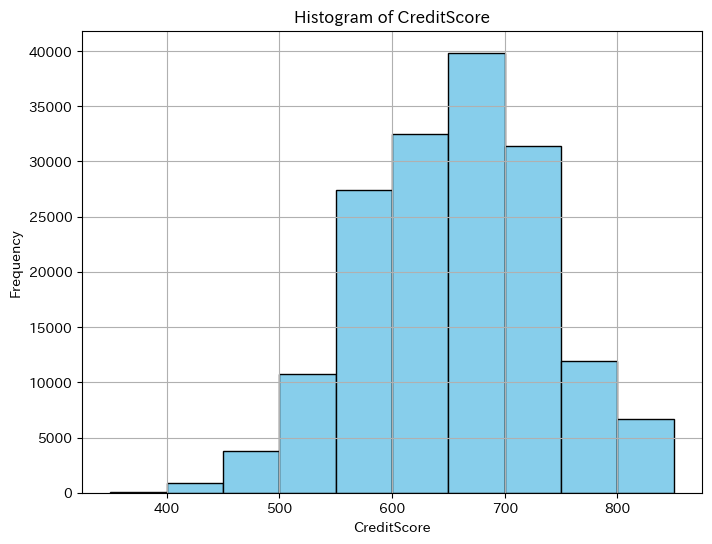

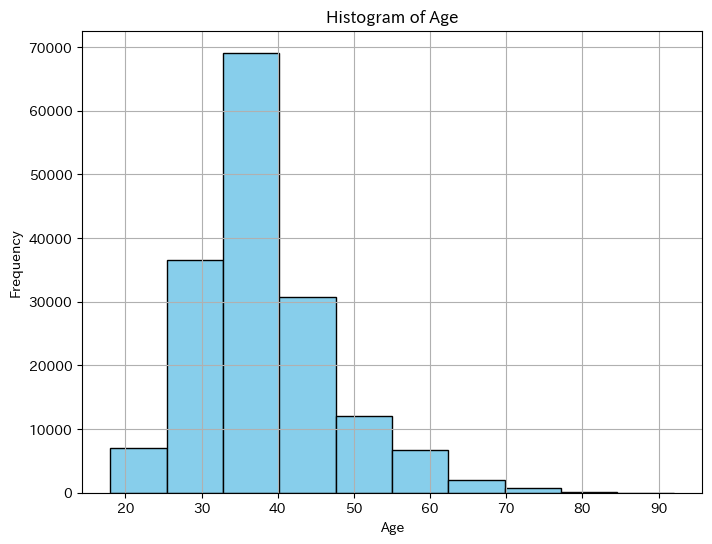

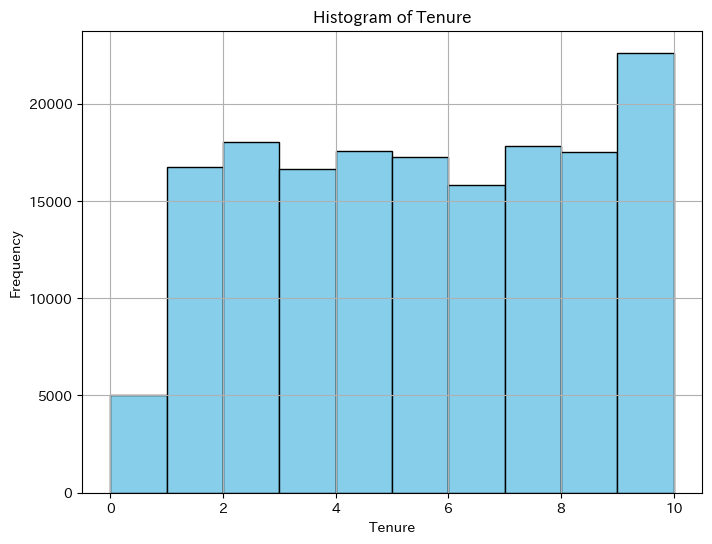

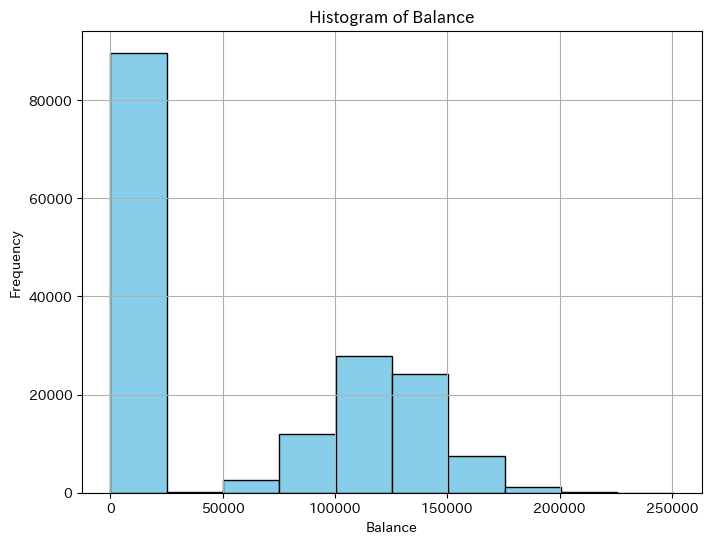

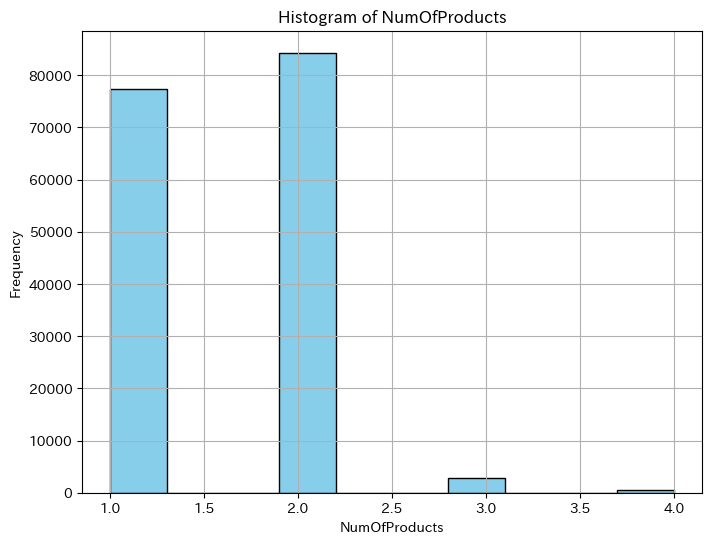

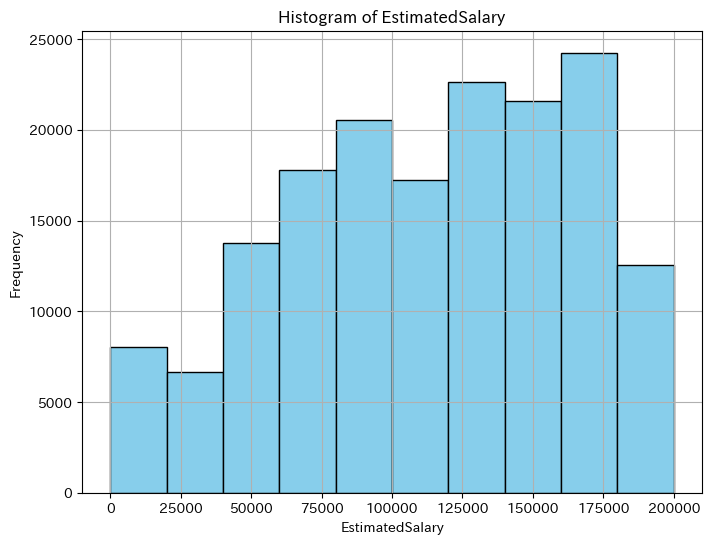

In [13]:
features=["CreditScore","Age","Tenure","Balance","NumOfProducts","EstimatedSalary"]
# 特徴量ごとにヒストグラムを描画
for feature in features:
    plt.figure(figsize=(8, 6))
    plt.hist(df_train[feature], bins=10, color='skyblue', edgecolor='black')
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

#### 標準化(IsActiveMember)

In [14]:
value_mean = df_train["IsActiveMember"].mean()
value_std = df_train["IsActiveMember"].std(ddof=0) #母集団の標準偏差を利用する場合
# value_std = df_train["Fare"].std() #標本の標準偏差を利用する場合
print("mean:", value_mean, ", std:", value_std)

df_train["IsActiveMember_standard"] = (df_train["IsActiveMember"] - value_mean) / value_std
df_train[["IsActiveMember", "IsActiveMember_standard"]].head()

mean: 0.49777015645260975 , std: 0.4999950277732901


,IsActiveMember,IsActiveMember_standard
0,0.0,-0.99555
1,1.0,1.00447
2,0.0,-0.99555
3,1.0,1.00447
4,1.0,1.00447


####  標準化（EstimatedSalary）

In [15]:
value_mean = df_train["EstimatedSalary"].mean()
value_std = df_train["EstimatedSalary"].std(ddof=0) #母集団の標準偏差を利用する場合
# value_std = df_train["Fare"].std() #標本の標準偏差を利用する場合
print("mean:", value_mean, ", std:", value_std)

df_train["EstimatedSalary_standard"] = (df_train["EstimatedSalary"] - value_mean) / value_std
df_train[["EstimatedSalary", "EstimatedSalary_standard"]].head()

mean: 112574.82273434385 , std: 50292.71321344768


,EstimatedSalary,EstimatedSalary_standard
0,181449.97,1.369486
1,49503.50,-1.254085
2,184866.69,1.437422
3,84560.88,-0.557018
4,15068.83,-1.938770


#### 正規化(IsActiveMember)

In [16]:
value_min = df_train["IsActiveMember"].min()
value_max = df_train["IsActiveMember"].max()
print("min:", value_min, ", max:", value_max)

df_train["IsActiveMember_normalize"] = (df_train["IsActiveMember"] - value_min) / (value_max - value_min)
df_train[["IsActiveMember", "IsActiveMember_normalize"]].head()

min: 0.0 , max: 1.0


,IsActiveMember,IsActiveMember_normalize
0,0.0,0.0
1,1.0,1.0
2,0.0,0.0
3,1.0,1.0
4,1.0,1.0


####  正規化（EstimatedSalary）

In [17]:
value_min = df_train["EstimatedSalary"].min()
value_max = df_train["EstimatedSalary"].max()
print("min:", value_min, ", max:", value_max)

df_train["EstimatedSalary_normalize"] = (df_train["EstimatedSalary"] - value_min) / (value_max - value_min)
df_train[["EstimatedSalary", "EstimatedSalary_normalize"]].head()

min: 11.58 , max: 199992.48


,EstimatedSalary,EstimatedSalary_normalize
0,181449.97,0.907279
1,49503.50,0.247483
2,184866.69,0.924364
3,84560.88,0.422787
4,15068.83,0.075293


# 特徴量生成

## 単変数：カテゴリ変数
## one-hot-encoding

In [19]:
### OneHotEncoderのインスタンスを作成し、sparse=Falseで密行列を指定
ohe_Gender=OneHotEncoder(sparse=False)

### OneHotEncoderを訓練データの"Gender"列に適させる
ohe_Gender.fit(df_train[["Gender"]])

### OneHotエンコーディングされた特徴量を含むDataFrameを作成し、列名を指定
tmp_Gender = pd.DataFrame(
    ### OneHotエンコーディングを実行し、結果をDataFrameに保存
    ohe_Gender.transform(df_train[["Gender"]]), 
    ### 列名を "Gender_Female", "Gender_Male" などに設定
    columns=["Gender_{}".format(i) for i in ohe_Gender.categories_[0]],
)

### 元のデータフレームとOneHotエンコーディングされた特徴量を結合
df_train = pd.concat([df_train, tmp_Gender], axis=1)

### "Embarked"列とOne-Hotエンコーディングされた列を抽出して表示
df_train[["Gender","Gender_Female","Gender_Male"]]


,Gender,Gender_Female,Gender_Male
0,Male,0.0,1.0
1,Male,0.0,1.0
2,Male,0.0,1.0
3,Male,0.0,1.0
4,Male,0.0,1.0
...,...,...,...
165029,Female,1.0,0.0
165030,Male,0.0,1.0
165031,Male,0.0,1.0
165032,Female,1.0,0.0


In [20]:
### OneHotEncoderのインスタンスを作成し、sparse=Falseで密行列を指定
ohe_Geography=OneHotEncoder(sparse=False)

### OneHotEncoderを訓練データの"Gendet"列に適させる
ohe_Geography.fit(df_train[["Geography"]])

### OneHotエンコーディングされた特徴量を含むDataFrameを作成し、列名を指定
tmp_Geography = pd.DataFrame(
    ### OneHotエンコーディングを実行し、結果をDataFrameに保存
    ohe_Geography.transform(df_train[["Geography"]]), 
    ### 列名を "Embarked_0", "Embarked_1" などに設定
    columns=["Geography_{}".format(i) for i in ohe_Geography.categories_[0]],
)

### 元のデータフレームとOneHotエンコーディングされた特徴量を結合
df_train = pd.concat([df_train, tmp_Geography], axis=1)

### "Embarked"列とOne-Hotエンコーディングされた列を抽出して表示
df_train[["Geography","Geography_France","Geography_Spain","Geography_Germany"]]


,Geography,Geography_France,Geography_Spain,Geography_Germany
0,France,1.0,0.0,0.0
1,France,1.0,0.0,0.0
2,France,1.0,0.0,0.0
3,France,1.0,0.0,0.0
4,Spain,0.0,1.0,0.0
...,...,...,...,...
165029,Spain,0.0,1.0,0.0
165030,France,1.0,0.0,0.0
165031,France,1.0,0.0,0.0
165032,Spain,0.0,1.0,0.0


In [21]:
##特徴量追加　　カテゴリ変数×数値→数値に変換
df_train['Gender_Male_and_Active'] = ((df_train['Gender'] == 'Male') & (df_train['IsActiveMember'] == 1)).astype(int)

In [22]:
##特徴量追加　　数値×数値
# Gender_MaleとIsActiveMemberを組み合わせて新しい特徴量を生成(加)
df_train["Gender_Male_+_Active"] = df_train["Gender_Male"] + df_train["IsActiveMember"]

# 新しい特徴量の確認
print(df_train[["Gender_Male", "IsActiveMember", "Gender_Male_+_Active"]].head())

   Gender_Male  IsActiveMember  Gender_Male_+_Active
0          1.0             0.0                   1.0
1          1.0             1.0                   2.0
2          1.0             0.0                   1.0
3          1.0             1.0                   2.0
4          1.0             1.0                   2.0


In [23]:
##count-encoding
# "Surname" 列の各値の出現回数を数え、その結果を辞書に変換し、変数 ce_Surname に代入します。
ce_Surname = df_train["Surname"].value_counts().to_dict()

# 出現回数の辞書を出力します。
print(ce_Surname)

# "Surname" 列の各値を、出現回数の辞書にマッピングし、新しい列 "Surname_ce" を作成します。
df_train["Surname_ce"] = df_train["Surname"].map(ce_Surname)

df_train[["Surname_ce"]]
# "Surname" 列と新しい "Surname_ce" 列を含む DataFrame の最初の数行を表示します。
df_train[["Surname", "Surname_ce"]].head()

{'Hsia': 2456, "T'ien": 2282, 'Hs?': 1611, 'Kao': 1577, 'Maclean': 1577, "Ts'ui": 1567, "P'eng": 1503, 'H?': 1420, 'Hsueh': 1306, 'Shih': 1251, "Ch'ang": 1229, "Ch'iu": 1199, 'Mazzanti': 1192, 'Tuan': 1164, 'Fanucci': 1139, 'Onyemauchechukwu': 1138, 'Tien': 1132, 'Smith': 1129, 'Nwankwo': 1117, 'Manna': 1024, 'Teng': 1008, 'Hsiung': 988, "Ch'ien": 974, 'Genovese': 962, 'Hsieh': 939, "T'ao": 906, "Ts'ai": 900, 'Trevisani': 894, 'Martin': 875, "T'ang": 859, 'Hsing': 853, 'Y?an': 846, 'Pirozzi': 814, 'Y?': 759, "K'ung": 754, "Ch'eng": 752, 'Walker': 744, 'Tsao': 740, 'Scott': 729, 'White': 727, 'Nwachinemelu': 726, 'Toscani': 723, "Ch'in": 722, 'Pinto': 717, 'Trevisano': 714, 'Brown': 713, 'Palerma': 708, 'L?': 694, 'Lucchesi': 689, 'Lo Duca': 687, 'Hsiao': 666, 'Ting': 663, 'Nwabugwu': 662, 'Ritchie': 645, 'Liao': 644, 'K?': 632, 'Lucciano': 627, 'Chukwudi': 615, 'Mazzi': 611, 'Chiu': 608, 'Tung': 604, 'Hao': 594, 'Lu': 592, 'Lai': 591, 'Lo': 589, 'Yeh': 584, 'Cremonesi': 581, 'Hsu': 580

,Surname,Surname_ce
0,Okwudilichukwu,261
1,Okwudiliolisa,300
2,Hsueh,1306
3,Kao,1577
4,Chiemenam,246


In [24]:
#特徴量生成　数値xカテゴリ変数
df_train["mean_Age_by_Surname"] = df_train.groupby("Surname")["Age"].transform("mean")
df_train[["Surname", "Age", "mean_Age_by_Surname"]].head()


,Surname,Age,mean_Age_by_Surname
0,Okwudilichukwu,33.0,39.708812
1,Okwudiliolisa,33.0,39.753333
2,Hsueh,40.0,38.189127
3,Kao,34.0,37.192771
4,Chiemenam,33.0,39.089431


In [25]:
#特徴量生成　数値xカテゴリ変数
df_train["std_Age_by_Surname"] = df_train.groupby("Surname")["Age"].transform("std")

df_train["sum_Age_by_Surname"] = df_train.groupby("Surname")["Age"].transform("sum")
df_train["max_Age_by_Surname"] = df_train.groupby("Surname")["Age"].transform("max")
df_train["min_Age_by_Surname"] = df_train.groupby("Surname")["Age"].transform("min")

In [26]:
# BalanceとNumOfProductsの四則計算の特徴量作成　（数値変数×数値変数）
df_train["Balance_-_NumOfProducts"] = df_train["Balance"] - df_train["NumOfProducts"]

In [27]:
#NumOfProductsとAgeの四則計算の特徴量作成　(数値変数×数値変数×）
df_train["NumOfProducts_+_Age"] = df_train["NumOfProducts"] + df_train["Age"]
df_train["NumOfProducts_-_Age"] = df_train["NumOfProducts"] - df_train["Age"]
df_train["NumOfProducts_*_Age"] = df_train["NumOfProducts"] * df_train["Age"]
df_train["NumOfProducts_/_Age"] = df_train["NumOfProducts"] / df_train["Age"]

df_train["NumOfProducts_*_CreditScore"] = df_train["NumOfProducts"] * df_train["CreditScore"]
df_train["NumOfProducts_/_CreditScore"] = df_train["NumOfProducts"] / df_train["CreditScore"]



In [28]:
#HasCrCard(数値)とTenure(数値)実施
df_train["Tenure_+_HasCrCard"] = df_train["Tenure"] + df_train["HasCrCard"]
df_train["Tenure_*_HasCrCard"] = df_train["Tenure"] * df_train["HasCrCard"]


In [29]:
# "Sex" 列と "Embarked" 列を基準に DataFrame をグループ化し、各グループ内の "PassengerId" 列の値の数を計算し、
# 新しい列 "count_Sex_x_Embarked" にその数を保存します。
df_train["count_Surname_x_Geography"] = df_train.groupby(["Surname", "Geography"])["id"].transform("count")

# "Sex" 列、"Embarked" 列、そして新しい "count_Sex_x_Embarked" 列を含む DataFrame の最初の数行を表示します。
df_train[["Geography","Surname", "count_Surname_x_Geography"]].head()


,Geography,Surname,count_Surname_x_Geography
0,France,Okwudilichukwu,117
1,France,Okwudiliolisa,150
2,France,Hsueh,782
3,France,Kao,1006
4,Spain,Chiemenam,52


In [30]:
# Geography 列と Surname 列を用いて DataFrame をクロス集計し、各行の合計で割った割合を求めます。
df_tbl = pd.crosstab(df_train["Geography"], df_train["Surname"], normalize="index")


df_tb1=pd.crosstab(df_train["Geography"],df_train["Surname"],normalize="index")

# 集約されたテーブルを表示します。行方向の和で割った割合が表示されます。
print("集約テーブル（行方向の和で割る）")
display(df_tbl)

# クロス集計された DataFrame のインデックスをリセットし、"Geography" 列を通常の列に戻します。
df_tbl = df_tbl.reset_index()

# データを縦持ち形式に変換し、"Geography" 列をキーとして、"Surname" 列とその割合を保持した新しい列 "rate_Geography_x_Surname" を作成します。
df_tbl = pd.melt(df_tbl, id_vars="Geography", value_name="rate_Geography_x_Surname")

# 変換されたテーブルを表示します。
print("集約テーブル（縦持ち変換後）")
display(df_tbl)

# 元の DataFrame と変換された DataFrame を "Geography" 列と "Surname" 列をキーとして左結合し、新しい列 "rate_Geography_x_Surname" を追加します。
df_train = pd.merge(df_train, df_tbl, on=["Geography", "Surname"], how="left")

# 最後に、元の DataFrame の最初の数行を表示し、"Geography" 列と "Surname" 列、そして新しい "rate_Geography_x_Surname" 列の値が表示されます。
print("結合後テーブル")
df_train[["Geography", "Surname", "rate_Geography_x_Surname"]].head()
#Exited


集約テーブル（行方向の和で割る）


Surname,Abazu,Abbie,Abbott,Abdullah,Abdulov,Abel,Abernathy,Abramov,Abramova,Abramovich,...,Zimmer,Zinachukwudi,Zito,Zotova,Zox,Zubarev,Zubareva,Zuev,Zuyev,Zuyeva
Geography,,,,,,,,,,,,,,,,,,,,,
France,0.000011,0.000042,0.000223,0.000011,0.000064,0.000032,0.000032,0.000021,0.000011,0.000106,...,0.000021,0.000032,0.000998,0.000032,0.000074,0.000074,0.000011,0.000106,0.000329,0.000276
Germany,0.000000,0.000000,0.000029,0.000000,0.000058,0.000000,0.000000,0.000000,0.000058,0.000000,...,0.000029,0.000000,0.001214,0.000000,0.000144,0.000000,0.000000,0.000116,0.000462,0.000405
Spain,0.000000,0.000000,0.000055,0.000000,0.000110,0.000000,0.000000,0.000028,0.000055,0.000387,...,0.000193,0.000000,0.001574,0.000000,0.000193,0.000000,0.000000,0.000138,0.000304,0.000552


集約テーブル（縦持ち変換後）


,Geography,Surname,rate_Geography_x_Surname
0,France,Abazu,0.000011
1,Germany,Abazu,0.000000
2,Spain,Abazu,0.000000
3,France,Abbie,0.000042
4,Germany,Abbie,0.000000
...,...,...,...
8386,Germany,Zuyev,0.000462
8387,Spain,Zuyev,0.000304
8388,France,Zuyeva,0.000276
8389,Germany,Zuyeva,0.000405


結合後テーブル


,Geography,Surname,rate_Geography_x_Surname
0,France,Okwudilichukwu,0.001242
1,France,Okwudiliolisa,0.001592
2,France,Hsueh,0.008300
3,France,Kao,0.010678
4,Spain,Chiemenam,0.001436


#### データセット作成（特徴量生追加） 

In [31]:
x_train,y_train,id_train=df_train[["IsActiveMember","EstimatedSalary","CreditScore",
                                  "Gender_Male","Age","Balance","Geography_Germany","Gender_Male_and_Active",
                                  "Gender_Male_+_Active","Surname","Surname_ce","mean_Age_by_Surname","std_Age_by_Surname","sum_Age_by_Surname","max_Age_by_Surname",
                                  "NumOfProducts","Balance_-_NumOfProducts","NumOfProducts_+_Age","NumOfProducts_-_Age","NumOfProducts_*_Age",
                                   "NumOfProducts_/_Age","NumOfProducts_*_CreditScore","NumOfProducts_/_CreditScore",
                                   "Tenure_+_HasCrCard","Tenure_*_HasCrCard","rate_Geography_x_Surname","count_Surname_x_Geography"]],\
                         df_train[["Exited"]],\
                        df_train[["id"]]
print(x_train.shape, y_train.shape, id_train.shape)


(165034, 27) (165034, 1) (165034, 1)


In [32]:
# DataFrame x_train の各列に対してループを行う
for col in x_train.columns:
    # もし列のデータ型が文字列型であれば
    
    if x_train[col].dtype=="O":
        # その列のデータ型をカテゴリ型に変換する
        x_train[col] = x_train[col].astype("category")

####  モデル学習・評価（特徴量追加後）

In [33]:
imp, metrics = train_cv(x_train, y_train, id_train, params, n_splits=5)

-------------------- 0 --------------------
(132027, 27) (132027, 1)
(33007, 27) (33007, 1)
y_train:0.212, y_tr:0.212, y_va:0.212
[1]	training's auc: 0.868941	valid_1's auc: 0.863059
Training until validation scores don't improve for 100 rounds
[2]	training's auc: 0.873896	valid_1's auc: 0.869854
[3]	training's auc: 0.876671	valid_1's auc: 0.872316
[4]	training's auc: 0.877797	valid_1's auc: 0.873443
[5]	training's auc: 0.878932	valid_1's auc: 0.874257
[6]	training's auc: 0.879427	valid_1's auc: 0.874909
[7]	training's auc: 0.879717	valid_1's auc: 0.875188
[8]	training's auc: 0.882525	valid_1's auc: 0.877691
[9]	training's auc: 0.883185	valid_1's auc: 0.878067
[10]	training's auc: 0.884623	valid_1's auc: 0.879187
[11]	training's auc: 0.885162	valid_1's auc: 0.879491
[12]	training's auc: 0.88664	valid_1's auc: 0.880908
[13]	training's auc: 0.887777	valid_1's auc: 0.881935
[14]	training's auc: 0.888623	valid_1's auc: 0.882511
[15]	training's auc: 0.89003	valid_1's auc: 0.883656
[16]	trai

In [34]:
imp.sort_values("imp", ascending=False, ignore_index=True)    

,col,imp,imp_std
0,NumOfProducts_/_Age,136284.982013,1492.453113
1,NumOfProducts,42475.285251,559.110296
2,Surname,33078.591264,1877.232194
3,Balance_-_NumOfProducts,18968.164980,1054.218117
4,IsActiveMember,15012.863636,196.290154
5,Gender_Male_+_Active,10784.127287,869.630903
6,Geography_Germany,9375.490042,684.611435
7,Gender_Male_and_Active,7483.077546,860.340771
8,Balance,7175.739586,1512.914244
9,NumOfProducts_+_Age,6191.909003,701.187161


In [35]:
##推論用データセットの作成 （特徴量エンジニアリング含）

In [36]:
df_test = pd.read_csv("Bank Churn/test.csv")


### OneHotEncoderのインスタンスを作成し、sparse=Falseで密行列を指定
ohe_Gender=OneHotEncoder(sparse=False)


### OneHotEncoderを訓練データの"Gendet"列に適させる

ohe_Gender.fit(df_test[["Gender"]])

### OneHotエンコーディングされた特徴量を含むDataFrameを作成し、列名を指定
tmp_Gender = pd.DataFrame(
    ### OneHotエンコーディングを実行し、結果をDataFrameに保存
    ohe_Gender.transform(df_test[["Gender"]]), 
    ### 列名を "Embarked_0", "Embarked_1" などに設定
    columns=["Gender_{}".format(i) for i in ohe_Gender.categories_[0]],
)


### 元のデータフレームとOneHotエンコーディングされた特徴量を結合
df_test = pd.concat([df_test, tmp_Gender], axis=1)
### "Embarked"列とOne-Hotエンコーディングされた列を抽出して表示
df_test[["Gender","Gender_Female","Gender_Male"]]



### OneHotEncoderのインスタンスを作成し、sparse=Falseで密行列を指定
ohe_Geography=OneHotEncoder(sparse=False)

### OneHotEncoderを訓練データの"Gendet"列に適させる
ohe_Geography.fit(df_test[["Geography"]])

### OneHotエンコーディングされた特徴量を含むDataFrameを作成し、列名を指定
tmp_Geography = pd.DataFrame(
    ### OneHotエンコーディングを実行し、結果をDataFrameに保存
    ohe_Geography.transform(df_test[["Geography"]]), 
    ### 列名を "Geography_0", "Geography_1" などに設定
    columns=["Geography_{}".format(i) for i in ohe_Geography.categories_[0]],
)

### 元のデータフレームとOneHotエンコーディングされた特徴量を結合
df_test = pd.concat([df_test, tmp_Geography], axis=1)

### "Embarked"列とOne-Hotエンコーディングされた列を抽出して表示
df_test[["Geography","Geography_France","Geography_Spain","Geography_Germany"]]



df_test['Gender_Male_and_Active'] = ((df_test['Gender'] == 'Male') & (df_test['IsActiveMember'] == 1)).astype(int)


df_test["Gender_Male_+_Active"] = df_test["Gender_Male"] + df_test["IsActiveMember"]


# "Surname" 列の各値の出現回数を数え、その結果を辞書に変換し、変数 ce_Surname に代入します。
ce_Surname = df_test["Surname"].value_counts().to_dict()


# "Surname" 列の各値を、出現回数の辞書にマッピングし、新しい列 "Surname_ce" を作成します。
df_test["Surname_ce"] = df_test["Surname"].map(ce_Surname)


#特徴量生成　数値xカテゴリ変数
df_test["mean_Age_by_Surname"] = df_test.groupby("Surname")["Age"].transform("mean")
df_test["std_Age_by_Surname"] = df_test.groupby("Surname")["Age"].transform("std")
df_test["sum_Age_by_Surname"] = df_test.groupby("Surname")["Age"].transform("sum")
df_test["max_Age_by_Surname"] = df_test.groupby("Surname")["Age"].transform("max")
df_test["min_Age_by_Surname"] = df_test.groupby("Surname")["Age"].transform("min")

#特徴量生成　数値x数値
df_test["Balance_-_NumOfProducts"] = df_test["Balance"] - df_test["NumOfProducts"]

df_test["NumOfProducts_+_Age"] = df_test["NumOfProducts"] + df_test["Age"]
df_test["NumOfProducts_-_Age"] = df_test["NumOfProducts"] - df_test["Age"]
df_test["NumOfProducts_*_Age"] = df_test["NumOfProducts"] * df_test["Age"]
df_test["NumOfProducts_/_Age"] = df_test["NumOfProducts"] / df_test["Age"]

df_test["NumOfProducts_-_CreditScore"] = df_test["NumOfProducts"] - df_test["CreditScore"]
df_test["NumOfProducts_*_CreditScore"] = df_test["NumOfProducts"] * df_test["CreditScore"]
df_test["NumOfProducts_/_CreditScore"] = df_test["NumOfProducts"] / df_test["CreditScore"]
df_test["Tenure_+_HasCrCard"] = df_test["Tenure"] + df_test["HasCrCard"]
df_test["Tenure_*_HasCrCard"] = df_test["Tenure"] * df_test["HasCrCard"]



df_test["count_Surname_x_Geography"] = df_test.groupby(["Surname","Geography"])["id"].transform("count")


# "Geography" 列と "Surname" 列を用いて DataFrame をクロス集計し、各行の合計で割った割合を求めます。
df_tbl = pd.crosstab(df_test["Geography"], df_test["Surname"], normalize="index")


df_tb1=pd.crosstab(df_test["Geography"],df_test["Surname"],normalize="index")

# 集約されたテーブルを表示します。行方向の和で割った割合が表示されます。
print("集約テーブル（行方向の和で割る）")
display(df_tbl)

# クロス集計された DataFrame のインデックスをリセットし、"Geography" 列を通常の列に戻します。
df_tbl = df_tbl.reset_index()

# データを縦持ち形式に変換し、"Geography" 列をキーとして、"Surname" 列とその割合を保持した新しい列 "rate_Sex_x_Embarked" を作成します。
df_tbl = pd.melt(df_tbl, id_vars="Geography", value_name="rate_Geography_x_Surname")

# 変換されたテーブルを表示します。
print("集約テーブル（縦持ち変換後）")
display(df_tbl)

# 元の DataFrame と変換された DataFrame を "Geography" 列と "Surname" 列をキーとして左結合し、新しい列 "rate_Geography_x_Surname" を追加します。
df_test = pd.merge(df_test, df_tbl, on=["Geography","Surname"], how="left")

# 最後に、元の DataFrame の最初の数行を表示し、"Geography" 列と "Surname" 列、そして新しい "rate_Geography_x_Surname" 列の値が表示されます。
print("結合後テーブル")
df_test[["Geography","Surname","rate_Geography_x_Surname"]].head()


x_test = df_test[["IsActiveMember","EstimatedSalary","CreditScore",
                                  "Gender_Male","Age","Balance","Geography_Germany","Gender_Male_and_Active",
                                  "Gender_Male_+_Active","Surname","Surname_ce","mean_Age_by_Surname","std_Age_by_Surname","sum_Age_by_Surname","max_Age_by_Surname",
                                  "NumOfProducts","Balance_-_NumOfProducts","NumOfProducts_+_Age","NumOfProducts_-_Age","NumOfProducts_*_Age",
                                   "NumOfProducts_/_Age","NumOfProducts_*_CreditScore","NumOfProducts_/_CreditScore",
                  "Tenure_+_HasCrCard","Tenure_*_HasCrCard","rate_Geography_x_Surname","count_Surname_x_Geography"]]                               

                  

id_test = df_test[["id"]]




集約テーブル（行方向の和で割る）


Surname,Abazu,Abbie,Abbott,Abdullah,Abdulov,Abel,Abernathy,Abramov,Abramova,Abramovich,...,Zinachukwudi,Zito,Zotov,Zotova,Zox,Zubarev,Zubareva,Zuev,Zuyev,Zuyeva
Geography,,,,,,,,,,,,,,,,,,,,,
France,0.000000,0.000016,0.000269,0.000047,0.000016,0.000016,0.000047,0.000016,0.000016,0.000063,...,0.000047,0.001076,0.000016,0.000032,0.000047,0.000047,0.000032,0.000127,0.000285,0.000427
Germany,0.000044,0.000000,0.000131,0.000000,0.000174,0.000000,0.000044,0.000000,0.000087,0.000044,...,0.000000,0.001613,0.000000,0.000000,0.000087,0.000000,0.000000,0.000000,0.000305,0.000349
Spain,0.000084,0.000000,0.000084,0.000000,0.000084,0.000000,0.000042,0.000000,0.000042,0.000418,...,0.000000,0.001505,0.000000,0.000000,0.000084,0.000042,0.000042,0.000084,0.000293,0.000293


集約テーブル（縦持ち変換後）


,Geography,Surname,rate_Geography_x_Surname
0,France,Abazu,0.000000
1,Germany,Abazu,0.000044
2,Spain,Abazu,0.000084
3,France,Abbie,0.000016
4,Germany,Abbie,0.000000
...,...,...,...
8119,Germany,Zuyev,0.000305
8120,Spain,Zuyev,0.000293
8121,France,Zuyeva,0.000427
8122,Germany,Zuyeva,0.000349


結合後テーブル


In [37]:
# DataFrame x_test の各列に対してループを行う
for col in x_test.columns:
    # もし列のデータ型が文字列型であれば
    
    if x_test[col].dtype=="O":
        # その列のデータ型をカテゴリ型に変換する
        x_test[col] = x_test[col].astype("category")

#モデル学習・評価（推論用データセット作成後）

In [38]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.1,
    'num_leaves': 16,
    'n_estimators': 100000,
    "random_state": 123,
    "importance_type": "gain",
}

def predict_lgb(input_x,
             input_y,
             input_id,
             params,
             n_splits=5,
            ):
    metrics = []
    imp = pd.DataFrame()

    cv = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123).split(input_x, input_y))
    for nfold in np.arange(n_splits):
        print("-"*20, nfold, "-"*20)
        idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
        x_tr, y_tr = input_x.loc[idx_tr, :], input_y.loc[idx_tr, :]
        x_va, y_va = input_x.loc[idx_va, :], input_y.loc[idx_va, :]
        print(x_tr.shape, y_tr.shape)
        print(x_va.shape, y_va.shape)
        print("y_train:{:.3f}, y_tr:{:.3f}, y_va:{:.3f}".format(
            input_y["Exited"].mean(),
            y_tr["Exited"].mean(),
            y_va["Exited"].mean(),
        ))

        model = lgb.LGBMClassifier(**params)
        model.fit(x_tr,
                  y_tr,
                  eval_set=[(x_tr,y_tr), (x_va,y_va)],
                  #early_stopping_rounds=100,
                  callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=True),
                  lgb.log_evaluation()], # コマンドライン出力用コールバック関数　修正処理
                  #verbose=10,
                  eval_metric='auc',  # 早期停止の評価メトリックスを指定するのが良いです
                  )


        y_tr_pred = model.predict_proba(x_tr)[:,1]
        y_va_pred = model.predict_proba(x_va)[:,1]
        metric_tr = roc_auc_score(y_tr, y_tr_pred)
        metric_va = roc_auc_score(y_va, y_va_pred)
        print("[accuracy] tr: {:.2f}, va: {:.2f}".format(metric_tr, metric_va))
        metrics.append([nfold, metric_tr, metric_va])

        _imp = pd.DataFrame({"col":input_x.columns, "imp":model.feature_importances_, "nfold":nfold})
        imp = pd.concat([imp, _imp], axis=0, ignore_index=True)

    print("-"*20, "result", "-"*20)
    metrics = np.array(metrics)
    print(metrics)

    print("[cv ] tr: {:.2f}+-{:.2f}, va: {:.2f}+-{:.2f}".format(
        metrics[:,1].mean(), metrics[:,1].std(),
        metrics[:,2].mean(), metrics[:,2].std(),
    ))

    imp = imp.groupby("col")["imp"].agg(["mean", "std"])
    imp.columns = ["imp", "imp_std"]
    imp = imp.reset_index(drop=False)

    print("Done.")

    return model

In [39]:
model = predict_lgb(x_train, y_train, id_train, params, n_splits=5)

-------------------- 0 --------------------
(132027, 27) (132027, 1)
(33007, 27) (33007, 1)
y_train:0.212, y_tr:0.212, y_va:0.212
[1]	training's auc: 0.868941	valid_1's auc: 0.863059
Training until validation scores don't improve for 100 rounds
[2]	training's auc: 0.873896	valid_1's auc: 0.869854
[3]	training's auc: 0.876671	valid_1's auc: 0.872316
[4]	training's auc: 0.877797	valid_1's auc: 0.873443
[5]	training's auc: 0.878932	valid_1's auc: 0.874257
[6]	training's auc: 0.879427	valid_1's auc: 0.874909
[7]	training's auc: 0.879717	valid_1's auc: 0.875188
[8]	training's auc: 0.882525	valid_1's auc: 0.877691
[9]	training's auc: 0.883185	valid_1's auc: 0.878067
[10]	training's auc: 0.884623	valid_1's auc: 0.879187
[11]	training's auc: 0.885162	valid_1's auc: 0.879491
[12]	training's auc: 0.88664	valid_1's auc: 0.880908
[13]	training's auc: 0.887777	valid_1's auc: 0.881935
[14]	training's auc: 0.888623	valid_1's auc: 0.882511
[15]	training's auc: 0.89003	valid_1's auc: 0.883656
[16]	trai

In [40]:
##学習モデルによる推論

In [41]:
y_test_pred = model.predict_proba(x_test)

In [42]:
 ##提出用ファイルの作成

In [43]:
df_submit = pd.DataFrame({"id": id_test["id"], "Exited": y_test_pred[:, 1]})
display(df_submit.head(5))
df_submit.to_csv("submission_lightgbm.csv", index=None)

,id,Exited
0,165034,0.014628
1,165035,0.769914
2,165036,0.024066
3,165037,0.274536
4,165038,0.375244
